In [1]:
from graphviz import Source
from copy import deepcopy
from termcolor import cprint

In [82]:
# Возвращает матрицу смежности для данного многообразия
# triangles -- массив граней
def get_graph(triangles):
    # максимальное число, встречающееся среди номеров вершин
    v_size = max(map(max, triangles)) + 1
    graph = [[0 for x in range(v_size)] for y in range(v_size)] 
    for triangle in triangles:
        for i in range(3):
            # добавляем ребро
            graph[triangle[i-1]][triangle[i]] += 1
    return graph

In [76]:
# Возвращает true, если граф связный
#           false, иначе
# graph - матрица смежности 
# (неориентированного графа) рамзмера n*n
def is_connected(graph):
    n = len(graph)
    used = [0] * n
    def dfs(u):   
        used[u] = 1
        for v in range(n):
            if (graph[u][v] or graph[v][u]) and not used[v]:
                dfs(v)  
    dfs(0)
    return sum(used) == n

In [78]:
# возвращает true, если 
# поверхность X ориентированна (то есть ориентация граней согласованна)
#           false, иначе
# graph - матрица смежности графа
def is_oriented(graph):
    n = len(graph)
    for u in range(n):
        for v in range(u + 1, n):
            # если ребра вообще нет, то ищем дальше
            if graph[u][v] + graph[v][u] == 0:
                continue
            # если ребро есть, то оно должно встречаться в двух направлениях
            if not graph[u][v] or not graph[v][u]:
                return False
    return True

In [81]:
# возвращает эйлерову характеристику симплициального многообразия
# triangles - мн-во граней
# graph - матрица смежности
def Euler(triangles, graph):
    v_size = len(graph)
    e_size = 0
    f_size = len(triangles)
    # считаем кол-во ребер
    for u in range(v_size):
        for v in range(u + 1, v_size):
            if graph[u][v] or graph[v][u]:
                e_size += 1
    # |V| - |E| + |F|
    return v_size - e_size + f_size

In [71]:
# возврашает true, если поверхность X является ориентируемой 
# (то есть можно ли выбрать согласованную ориентацию граней)
#          false, иначе
# triangles - мн-во граней
def is_orientable(triangles, debug=False):
    graph = get_graph(triangles)
    # проверяем, не является ли поверхность уже ориентированной
    if is_oriented(graph):
        if debug:
            cprint('\talready oriented', 'blue', attrs=['bold'])
        return True
    triangles = deepcopy(triangles)    

    # рекурсивно подбираем ориентацию граней
    def rec(i):
        if i == len(triangles):
            # если нашли нужную ориентацию
            if is_oriented(graph):
                return (True, triangles)
            return (False, [])
        result = rec(i + 1)
        if result[0] == True:
            return result
        # меняем ориентацию грани
        triangle = triangles[i]
        a, b, c = triangle
        triangles[i] = (b, a, c)
        graph[a][b] -= 1; graph[b][c] -= 1; graph[c][a] -= 1
        graph[b][a] += 1; graph[c][b] += 1; graph[a][c] += 1
        result = rec(i + 1)
        if result[0] == True:
            return result
        return (False, [])
            
    result = rec(0)
    if not result[0]:
        return False
    # если нашли согласованную ориентацию
    if debug:
        cprint('\tnew orientation: %s' % result[1], 'blue', attrs=['bold'])
    return True

In [83]:
# возвращает true, если 
# комплекс X является симплициальной поверхностью без края
#           false, иначе
# graph - матрица смежности
# debug - если True,
# то выводит, какие вершины не образуют цикл (при наличии)
def is_surface(graph, debug=False):
    # проверяет, образуют ли вершины vers цикл в графе
    def form_cycle(vers):
        n = len(vers)
        used = [0] * (len(graph) + 1)
        visited = [0]
        found_cycle = [False]
        # рекурсивный обход в глубину с подсчетом длины пути
        def dfs(prev, u):
            if found_cycle[0]:
                return
            used[u] = 1
            # считаем, сколько вершин посетили
            visited[0] += 1
            # если зациклились
            if visited[0] == n + 1:
                found_cycle[0] = True
                return
            for v in vers:
                if v == prev or graph[u][v] + graph[v][u] == 0:
                    continue
                if visited[0] == n:
                    if v == vers[0]:
                        dfs(u, v)
                elif used[v] == 0:
                        dfs(u, v)
            used[u] = 0
            visited[0] -= 1
        dfs(-1, vers[0])
        return found_cycle[0]
    # для каждой вершины проверяем,
    # образуют ли ее соседи цикл
    n = len(graph)
    for u in range(n):
        neighbors = []
        for v in range(n):
            if graph[u][v] or graph[v][u]:
                neighbors.append(v)
        flag = form_cycle(neighbors)
        if not flag:
            if debug:
                cprint(
                    '\tfor vertex #%s neighbors are: %s don\'t form a cycle' 
                    % (u, neighbors), 'blue', attrs=['bold'])
            return False
    # проверка, что каждое ребро встречается дважды
    for i in range(len(graph)):
        for j in range(len(graph)):
            if graph[i][j] + graph[j][i] != 0 and graph[i][j] + graph[j][i] != 2:
                return False
    return True

In [90]:
# получаем graphviz-код для многообразия
# triangles - массив граней
# graph - матрица смежности
# label - название многообразия
# specs - дополнительные параметры изображения
def get_source(triangles, graph, label, specs=''):
    # заготовка для кода
    s = \
    '''
    digraph {
    graph [label="%s"]
    node [shape=circle]
    ''' % label
    s += specs
    # добавляем все вершины
    st = set()
    for triangle in triangles:
        for number in triangle:
            if number not in st:
                s += str(number) + " "
                st.add(number)
    s += "\n"
    # добавляем ребра
    for u in range(len(graph)):
        for v in range(u + 1, len(graph)):
            if graph[u][v] and not graph[v][u]:
                s += "%s->%s\n" % (u, v)
            if not graph[u][v] and graph[v][u]:
                s += "%s->%s\n" % (v, u)
            if graph[u][v] and graph[v][u]:
                s += "%s->%s [dir = both] \n" % (u, v)
            if not graph[u][v] and not graph[v][u]:
                pass

    s = s + "}"
    return s

In [85]:
# сохраняем файл с кодом в текущую директорию 
def render_graph(source):
    src = Source(source)
    src.render()

In [88]:
# выводим результаты работы всех ф-ций из условия
def show_results(triangles, name, debug=False, specs=''):
    graph = get_graph(triangles)
    source = get_source(triangles, graph, name, specs)
    render_graph(source)

    print('is_connected = ', is_connected(graph))
    print('is_oriented = ', is_oriented(graph))
    print('Euler = ', Euler(triangles, graph))
    print('is_surface = ', is_surface(graph, debug))
    print('is_orientable = ', is_orientable(triangles, debug))

### Нарисуем сферу

is_connected =  True
is_oriented =  True
Euler =  2
is_surface =  True
	already oriented
is_orientable =  True


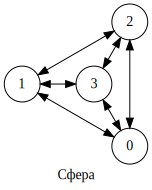

In [73]:
sphere = arrays['sphere']

show_results(sphere, 'Сфера', debug=True)

Source.from_file('Source.gv', engine='twopi')

Действительно, видно, что это поверхность и она связна и ориентированна

### Тор

is_connected =  True
is_oriented =  True
Euler =  0
is_surface =  True
	already oriented
is_orientable =  True


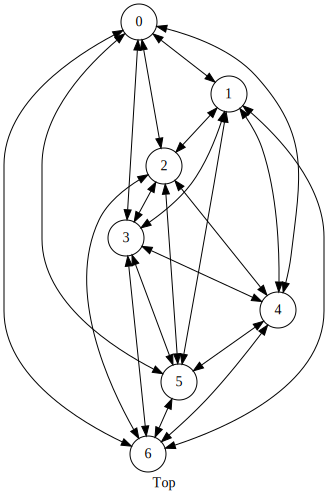

In [104]:
torus = arrays['torus']

#                                      изобразим горизонтально
show_results(torus, 'Тор', debug=True, specs='')

Source.from_file('Source.gv', engine='dot')

Аналогично, видно, что это поверхность и она связна и ориентированна

### Посмотрим на комплексы, которые не являются симплициальной поверхностью без края

is_connected =  True
is_oriented =  True
Euler =  2
	for vertex #0 neighbors are: [1, 2] don't form a cycle
is_surface =  False
	already oriented
is_orientable =  True


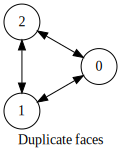

In [14]:
duplicate_faces = [(1,2,0), (1,0,2)]

show_results(duplicate_faces, 'Duplicate faces', debug=True)

Source.from_file('Source.gv', engine='circo')

Видим, что соседи любой из вершин не образуют цикл

### Другой пример

is_connected =  True
is_oriented =  False
Euler =  2
is_surface =  False
is_orientable =  False


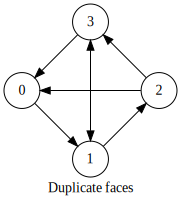

In [40]:
duplicate_faces = [(1,2,3), (2,3,1), (3,0,1),(0,1,2)]

show_results(duplicate_faces, 'Duplicate faces', debug=True)

Source.from_file('Source.gv', engine='circo')

Ребро (1, 2) встречается трижды

### Еще один пример

is_connected =  True
is_oriented =  False
Euler =  1
	for vertex #0 neighbors are: [1, 2] don't form a cycle
is_surface =  False
is_orientable =  False


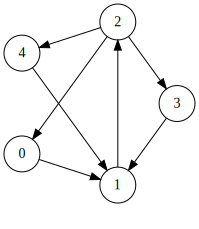

In [42]:
smth = [(1,2,0), (1,2,3), (1,2,4)]

show_results(smth, ' ',debug=True)

Source.from_file('Source.gv', engine='circo')

Действительно, соседи вершины 0 -- вершины 1 и 2 не образуют цикл

### Изобразим квадрат

is_connected =  True
is_oriented =  False
Euler =  1
	for vertex #0 neighbors are: [1, 2, 3] don't form a cycle
is_surface =  False
is_orientable =  False


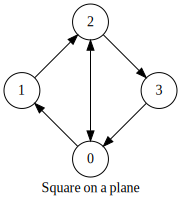

In [43]:
square_on_a_plane = [(0, 1, 2), (0, 2, 3)]

show_results(square_on_a_plane, 'Square on a plane', debug=True)

Source.from_file('Source.gv', engine='circo')

Аналогично, соседи вершины 0 -- вершины 1, 2 и 3 не образуют цикл

is_connected =  True
is_oriented =  False
Euler =  1
is_surface =  False
is_orientable =  False


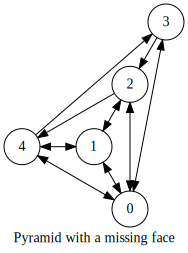

In [44]:
pyramid_with_a_missing_face = [(1,0,2), (2,0,3), (3,0,4), (0,1,4), (1,2,4)]

show_results(pyramid_with_a_missing_face, 
             'Pyramid with a missing face', debug=True)

Source.from_file('Source.gv', engine='twopi')

Ребро (4, 3) встречается один раз

### Две пирамиды

is_connected =  True
is_oriented =  True
Euler =  3
	for vertex #8 neighbors are: [0, 1, 2, 3, 4, 5, 6, 7] don't form a cycle
is_surface =  False
	already oriented
is_orientable =  True


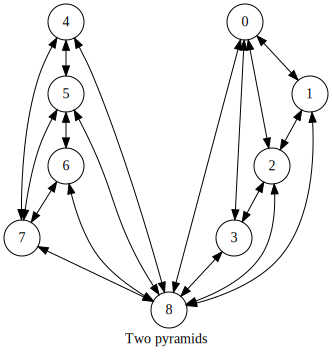

In [45]:
two_pyramids = arrays['two pyramids']

show_results(two_pyramids, 'Two pyramids', debug=True)

Source.from_file('Source.gv', engine='dot')

### На этом рассмотрение комплексов, которые не явлются симплициальной поверхностью без края окончено, далее будем смотреть только на поверхности:

### Пирамида

is_connected =  True
is_oriented =  True
Euler =  2
is_surface =  True
	already oriented
is_orientable =  True


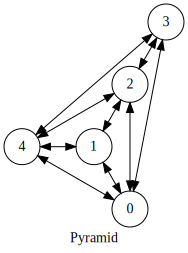

In [48]:
pyramid = arrays['pyramid']

show_results(pyramid, 'Pyramid', debug=True)

Source.from_file('Source.gv', engine='twopi')

### Икосаэдр

is_connected =  True
is_oriented =  True
Euler =  2
is_surface =  True
	already oriented
is_orientable =  True


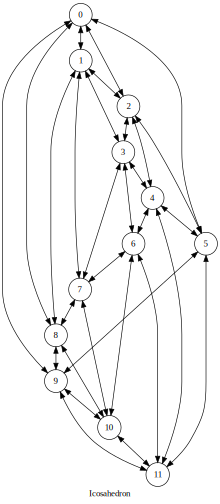

In [114]:
icosahedron = arrays['icosahedron']

show_results(icosahedron, 'Icosahedron', debug=True, specs='\nsize=7\n')

Source.from_file('Source.gv', engine='dot')

###  Бутылка Клейна
Это пример неориентируемой поверхности

is_connected =  True
is_oriented =  False
Euler =  0
is_surface =  True
is_orientable =  False


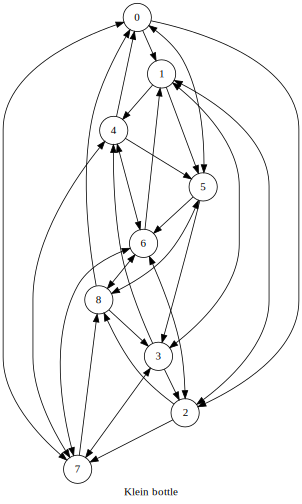

In [118]:
klein_bottle = arrays['klein bottle']

show_results(klein_bottle, 'Klein bottle', debug=True, specs='\nsize=7\n')

Source.from_file('Source.gv', engine='dot')

### Сфера с двумя ручками

is_connected =  True
is_oriented =  True
Euler =  -2
is_surface =  True
	already oriented
is_orientable =  True


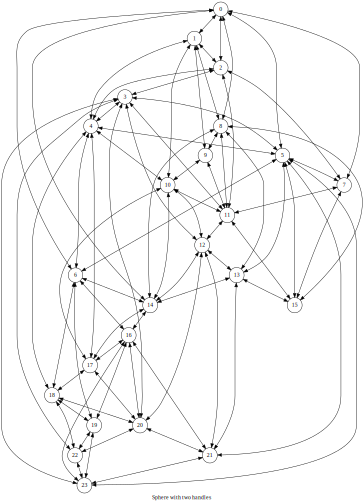

In [109]:
sphere_with_two_handles = arrays['sphere with two handles']

show_results(sphere_with_two_handles, 'Sphere with two handles', 
             debug=True, specs='\nsize=7\n')

Source.from_file('Source.gv', engine='dot')

### Два разделенных тетраэдра
Это пример несвязной поверхности

is_connected =  False
is_oriented =  True
Euler =  4
is_surface =  True
	already oriented
is_orientable =  True


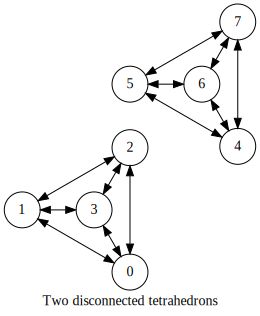

In [52]:
two_disconnected_tetrahedrons = [(3,2,1), (2,3,0), (1,0,3),(0,1,2), 
                                 (6,5,4), (5,6,7), (4,7,6),(7,4,5)]

show_results(two_disconnected_tetrahedrons, 
             'Two disconnected tetrahedrons', debug=True, specs='')

Source.from_file('Source.gv', engine='twopi')

### Теперь рассмотрим несколько примеров неориентированных, но ориентируемых поверхностей:

is_connected =  True
is_oriented =  False
Euler =  2
is_surface =  True
	new orientation: [(1, 2, 3), (0, 3, 2), (3, 0, 1), (1, 0, 2)]
is_orientable =  True


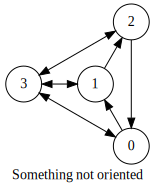

In [56]:
smth = [(1,2,3), (0,3,2), (3,0,1), (0,1,2)]

show_results(smth, 'Something not oriented', debug=True, specs='')

Source.from_file('Source.gv', engine='twopi')

Действительно, видно, что данная поверхность не является ориентированной, но давайте попробуем теперь изобразить поверхность, полученную из исходной с помощью изменения ориентации в последней грани:

is_connected =  True
is_oriented =  True
Euler =  2
is_surface =  True
	already oriented
is_orientable =  True


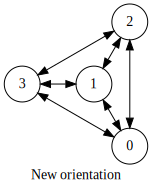

In [57]:
new_orientation = [(1, 2, 3), (0, 3, 2), (3, 0, 1), (1, 0, 2)]

show_results(new_orientation, 'New orientation', debug=True, specs='')

Source.from_file('Source.gv', engine='twopi')

Видно, что поверхность стала ориентированной, соответственно, исходную поверхность можно считать ориентируемой.

### Еще один аналогичный пример:

is_connected =  True
is_oriented =  False
Euler =  2
is_surface =  True
	new orientation: [(1, 2, 3), (3, 2, 0), (3, 0, 1), (1, 0, 2)]
is_orientable =  True


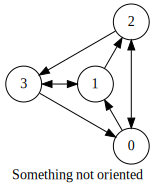

In [60]:
smth = [(1,2,3), (2,3,0), (3,0,1), (0,1,2)]
show_results(smth, 'Something not oriented', debug=True, specs='')

# test_oriented === False
# test_orientable === True

Source.from_file('Source.gv', engine='twopi')

is_connected =  True
is_oriented =  True
Euler =  2
is_surface =  True
	already oriented
is_orientable =  True


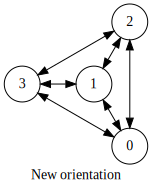

In [59]:
new_orientation = [(1, 2, 3), (3, 2, 0), (3, 0, 1), (1, 0, 2)]

show_results(new_orientation, 'New orientation', debug=True, specs='')

Source.from_file('Source.gv', engine='twopi')

Аналогично, после преобразования мы получили ориентированную поверхность

В принципе, мы уже рассмотрели почти все примеры из тестов, но давайте убедимся, что ответы действительно верные:

In [89]:
!python3.7 test.py

.....
----------------------------------------------------------------------
Ran 5 tests in 4.914s

OK


In [5]:
arrays = {
      'sphere': [(3,2,1), (2,3,0), (1,0,3),(0,1,2)],
      'torus': [
        (1,0,3),
        (1,3,2),
        (2,3,6),
        (3,4,6),
        (4,0,6),
        (1,6,0),
        (2,6,5),
        (1,5,6),
        (2,5,0),
        (3,0,5),
        (5,4,3),
        (1,4,5),
        (1,2,4),
        (2,0,4),
      ],
      'icosahedron': [[0, 1, 2],
                       [3, 2, 1],
                       [7, 3, 1],
                       [8, 1, 0],
                       [7, 1, 8],
                       [8, 0, 9],
                       [10, 7, 8],
                       [8, 9, 10],
                       [10, 6, 7],
                       [7, 6, 3],
                       [3, 6, 4],
                       [3, 4, 2],
                       [0, 2, 5],
                       [4, 5, 2],
                       [5, 4, 11],
                       [6, 11, 4],
                       [10, 11, 6],
                       [11, 10, 9],
                       [5, 11, 9],
                       [0, 5, 9]
                      ],
      'two pyramids': [[8, 6, 7],
                        [8, 7, 4],
                        [4, 5, 8],
                        [8, 5, 6],
                        [6, 5, 7],
                        [4, 7, 5],
                        [8, 1, 2],
                        [8, 2, 3],
                        [3, 0, 8],
                        [8, 0, 1],
                        [2, 1, 0],
                        [3, 2, 0]
                       ],
        'sphere with two handles': [[0, 6, 5],
                                   [5, 7, 0],
                                   [6, 4, 5],
                                   [4, 3, 5],
                                   [2, 1, 0],
                                   [7, 2, 0],
                                   [4, 1, 2],
                                   [2, 3, 4],
                                   [9, 11, 8],
                                   [8, 11, 15],
                                   [11, 9, 10],
                                   [11, 10, 12],
                                   [12, 10, 14],
                                   [14, 13, 12],
                                   [8, 15, 13],
                                   [8, 13, 14],
                                   [1, 10, 9],
                                   [10, 1, 4],
                                   [4, 17, 10],
                                   [17, 4, 18],
                                   [18, 4, 6],
                                   [1, 9, 8],
                                   [0, 1, 8],
                                   [14, 0, 8],
                                   [14, 6, 0],
                                   [6, 14, 16],
                                   [10, 17, 14],
                                   [17, 16, 14],
                                   [16, 19, 6],
                                   [19, 18, 6],
                                   [18, 20, 17],
                                   [20, 18, 22],
                                   [16, 17, 20],
                                   [16, 20, 21],
                                   [18, 19, 22],
                                   [23, 22, 19],
                                   [16, 21, 23],
                                   [16, 23, 19],
                                   [2, 11, 3],
                                   [2, 7, 11],
                                   [11, 7, 15],
                                   [7, 5, 15],
                                   [5, 13, 15],
                                   [5, 21, 13],
                                   [12, 13, 21],
                                   [21, 20, 12],
                                   [5, 23, 21],
                                   [5, 3, 23],
                                   [22, 23, 3],
                                   [20, 22, 3],
                                   [20, 3, 12],
                                   [3, 11, 12]
                                  ],
      'pyramid': [(1,0,2), (2,0,3), (3,0,4), (4,0,1), (1,2,4), (2,3,4)],
      'klein bottle': [(0,1,4), (1,4,6), (1,2,6), (2,7,6), (2,7,0), (0,7,4),
                      (4,5,6), (5,6,8), (6,7,8), (7,8,3), (4,7,3), (3,4,5), 
                      (5,8,0), (0,2,8), (8,3,2), (2,1,3), (3,1,5), (1,5,0)],
    }